In [1]:
# Getting the Libraries I Need
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Model Specific Libraries
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# Blocking Warning Boxes
import warnings
warnings.filterwarnings("ignore")

# Import my own "wrangle" Module 
import wrangle

# Remove Limits On Viewing Dataframes
pd.set_option('display.max_columns', None)

# Centers my charts in the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


<img src="Images/zillow_logo.png" alt="Zillow Logo" title="Zillow Logo" width="300" height="100" align="right"/>
 
  
# <p style="font-size:50px" align="center">The Price is Right!</p> <sub>by Jeanette Schulz 2021-12-13</sub>


    

<hr style="border:2px solid blue"> </hr>



# Goals
Zillow has a model that is designed to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017. The goal of this project is to look for insights that can help possibly improve this model, and make recommendations on how to improve it. 

<hr style="border:2px solid blue"> </hr>

# Planning
1. Setup my repository environment (.gitignore, README.md)
2. Import and test my wrangle functions
3. Define an test at least two hypothesis’s 
4. Train and Evalutate three different classification models.
5. Create a csv file with predictions, from the model that perfoms the best
6. Report my conclusions and next steps in a presentation.

<hr style="border:2px solid blue"> </hr>

# Executive Summary
My OLS Regressor Model had a Root Mean Squared Error (RMSE) of \\$215,650.06, beating my Baseline RMSE of \\$245,317.96.
That's an improvement of $29,667.

The data suggest Bathrooms, Bedrooms, and Squarefeet to be the most valued features. I recommend removing outliers from these columns to improve future modeling.


<hr style="border:2px solid blue"> </hr>



# Acquiring the Data
To acquire the Zillow data, I used the zillow database in the Codeup SQL server, and selected the requested columns. I then selected only Single Family Residential from the 2017 properties using propertylandusetypeid.
> SELECT bedroomcnt, 
> bathroomcnt, 
> calculatedfinishedsquarefeet, 
> yearbuilt, 
> regionidzip, 
> fips,
> taxvaluedollarcnt  
> FROM properties_2017  
> JOIN predictions_2017 USING (parcelid)  
> WHERE propertylandusetypeid = 261; 
 

In [2]:
zillow = wrangle.get_zillow_data()
zillow.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0


In [3]:
zillow.shape

(52442, 7)

<hr style="border:2px solid blue"> </hr>


# Preparing the Data


To clean the data, I did the following:

#### 1. Dropping all rows with NULL values:  
I decided to drop all NULLS because removing them removed less than 1% of my overall data. So it wouldn't affect my exploration or modeling if I dropped them.

#### 2. Dropping all rows that had any value as Zero.
Having a zero bedroom house does not make sense. I believed zeros in my data to be as bad as NULLS. Therefore I removed them to improve future modeling.

#### 3. Converting 4 columns  to an integer dtype:
From the database regionidzip, bedrooms, year_built, and fips were represented as floats. Seeing as all of these are supposed to represent whole numbers, I decided to change these comluns to be integers.


#### 4. Removing outliers from 'bedrooms', 'bathrooms', 'squarefeet', and 'tax_value'.
There were some extremely large houses with 17 bathrooms that I believed would not represent the average Single Family Residential. So I removed these with statistics upper and lower bounds.

#### 5. Feature Engineering a column named 'years_old'.  
To make it easier to see how old a house was in 2017, I simply made a column that subtracted the year_built from 2017.

 

 


In [4]:
telco = wrangle.prepare_zillow(wrangle.get_zillow_data())
telco.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,years_old
0,4,3.5,3100.0,1998,96978,6059,1023282.0,19
1,2,1.0,1465.0,1967,97099,6111,464000.0,50
2,3,2.0,1243.0,1962,97078,6059,564778.0,55
3,4,3.0,2376.0,1970,96330,6037,145143.0,47
4,4,3.0,2962.0,1950,96293,6037,773303.0,67


<hr style="border:2px solid blue"> </hr>

# Explore the Train dataset





In [5]:
# Using the functions from my compiled wrangle file
train, validate, test = wrangle.wrangle_zillow()

In [6]:
# Assigning my features to X, and target variable to y, for each split dataframe

X_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

X_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

X_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

Select Kbest

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression

# Parameters: f_regression stats test, give me 2 features
f_selector = SelectKBest(f_regression, k=2)

# Find the top 2 X's correlated with y
f_selector.fit(X_train, y_train)

# Boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# Get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

print("KBest Top Two Features:", f_feature)

KBest Top Two Features: ['bathrooms', 'squarefeet']


Recursive Feature Elimination

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 2)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

print("Recursive Feature Elimination Top Two Features:",rfe_feature)

# view list of columns and their ranking
# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

Recursive Feature Elimination Top Two Features: ['bedrooms', 'bathrooms']


,Var,Rank
0,bedrooms,1
1,bathrooms,1
5,fips,2
3,year_built,3
2,squarefeet,4
6,years_old,5
4,regionidzip,6


Two different models put bathrooms at the top of the list (Kbest comes in reverse order). With this, I will assume my top three features to be Bathrooms, Bedrooms, and Squarefeet. I'll explore the other features with some statistical tests to check if they meet common knowledge.

In [9]:
# Assuming a confidence level of 95% 
alpha = 0.05

#### 1. Are homes with more bedrooms worth more?
- H<sub>0</sub>: There is no difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.
- H<sub>a</sub>: There is a difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.



In [10]:
# I'm going to create some array's for this question
tax_value_2Bd = train[train.bedrooms == 2].tax_value
tax_value_5Bd = train[train.bedrooms == 5].tax_value

# This is a two-sampled, two-tailed test. 
t, p = stats.ttest_ind(tax_value_2Bd, tax_value_5Bd, equal_var=False)

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


>Conclusion: There is a difference in tax_value between homes with 2 bedrooms vs homes with 5 bedrooms.
>
>Takeaway: The data shows that increased bedroom count correlates with increased tax_value.

This can also be seen with this chart, comparing homes with different bedroom counts to thier tax value:

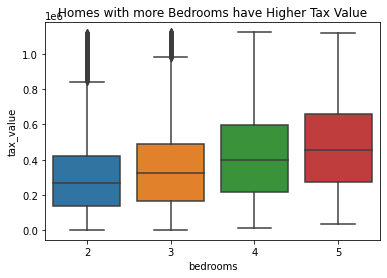

In [11]:
sns.boxplot(x= 'bedrooms', y= 'tax_value', data= train)
plt.title('Homes with more Bedrooms have Higher Tax Value')
plt.show();

2. Are younger homes higher in tax_value than old homes?
- H<sub>0</sub>: Homes older than the average cost more or the same as homes younger than the average
- H<sub>a</sub>: Homes older than the average cost less than homes younger than the average


In [12]:
# Defining the arrays i want for my t-test
older_homes = train[train.years_old >= train.years_old.mean()].tax_value
younger_homes = train[train.years_old < train.years_old.mean()].tax_value

# Define my hypothesis before testing:
# H0: Homes older than the average cost more or the same as homes younger than the average
# Ha: Homes older than the average cost less than homes younger than the average

# use stats.ttest to calculate t and p
t, p = stats.ttest_ind(older_homes, younger_homes, equal_var=False)

if p/2 < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


>Conclusion: Homes older than the average cost less than homes younger than the average.
>
>Takeaway: Year_built was number 3 in most valued features, so this makes sense. Younger homes have higher tax value than older homes. 

This chart shows tax_value of homes through the years:

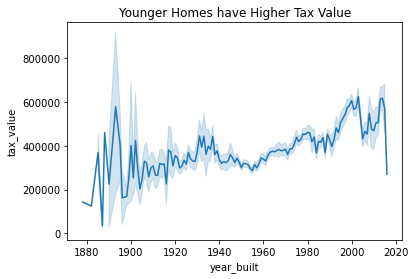

In [13]:
sns.lineplot(x= 'year_built', y= 'tax_value', data= train)
plt.title('Younger Homes have Higher Tax Value')
plt.show();

<hr style="border:2px solid blue"> </hr>

# Model and Evaluation

<hr style="border:2px solid blue"> </hr>




## Baseline Model

In [14]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# The Project specs told us to use mean for our baseline
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** (0.5)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** (0.5)

metric_df = pd.DataFrame(data=[
            {
                'model': 'Baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,243722.125753,245317.957751


## Three Models, One Dataframe

In [15]:
# Linear Regression Modeling
lr = LinearRegression()
lr.fit(X_train, y_train.tax_value)
y_train['tax_value_pred_LR'] = lr.predict(X_train)
y_validate['tax_value_pred_LR'] = lr.predict(X_validate)
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_LR) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_LR) ** (1/2)

# Add model results to results dataframe
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

# LassoLars
lars = LassoLars(alpha=0.01)
lars.fit(X_train, y_train.tax_value)
y_train['tax_value_lassolars'] = lars.predict(X_train)
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_lassolars) ** (1/2)
y_validate['tax_value_lassolars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_lassolars) ** (1/2)
metric_df = metric_df.append({
    'model': 'LassoLars', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)


# Tweedie Regressor
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train, y_train.tax_value)
y_train['tax_value_pred_glm'] = glm.predict(X_train)
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm) ** (1/2)

metric_df = metric_df.append({
    'model': 'Tweedie Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,243722.125753,245317.957751
1,OLS Regressor,215650.064606,217342.952446
2,LassoLars,215650.064679,217342.981245
3,Tweedie Regressor,243722.125753,245317.957751



## Model Takeaways:
OLS Regressor and LassoLars did better than my Baseline Model.

### The OLS Regressor Model had the best Root Mean Squared Error. 
- Validate Dataset had an RMSE of \\$217,342.95, which is better by \\$29,667.

I will use OLS Regressor for my Test Dataset!

In [16]:
y_test = pd.DataFrame(y_test)

# Linear Regression Modeling
lr = LinearRegression()
lr.fit(X_train, y_train.tax_value)
y_test['tax_value_pred_LR'] = lr.predict(X_test)
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_LR) ** (1/2)

print('$', round(rmse_test, 2))


$ 217529.43


## My test dataset had a RMSE of \\$217,529.43 which is better than my Baseline by \\$26,192.70

<hr style="border:2px solid blue"> </hr>


# Summary

My OLS Regressor Model had a Root Mean Squared Error (RMSE) of \\$215,650.06, beating my Baseline RMSE of \\$245,317.96.
That's an improvement of $29,667.

If I had more time, I would have liked to have made some loops for testing a variety of hyperparameters for each model to further improve RMSE.

# Recommendations
The data suggest Bathrooms, Bedrooms, and Squarefeet to be the most valued features. I recommend removing outliers from these columns to improve future modeling.


# Thank You!

